# **The use of pulsar signal data in pulsar candidate labeling (and classification?)**

### **Introduction**

Pulsars are a rare type of star belonging to a family of objects called neutron stars, and hence aren’t considered “living” stars. They produce pulses of radio emission in opposite directions, causing a spin on its axis of rotation and allowing it to appear as though it is “pulsing”. Pulsars are of great scientific interest due to their usage in studying states of matter, the interstellar medium, space-time, and solar systems, as well as in measuring cosmic distances (Roberts, Lorimer, and Kramer, 2005).

Pulsars, who are smaller and fainter compared to other celestial objects, are traditionally identified using all-sky surveys. Such surveys are conducted using radio telescopes from all around the world. Alternative approaches to identifying and labeling pulsars that utilize machine learning tools are also being considered and employed, due to their ability for fast processing of large datasets (Cofield, 2016). For example, training data subsets of already classified (as either pulsar or not pulsar) candidates can be fed into a binary classification system, which can then be applied to unclassified pulsar candidate data.

One such source of classified (training) and unclassified (testing) pulsar candidate data is Kaggle’s Predicting Pulsar Star database (Co-learning Lounge, 2020). The Kaggle database contains 12,528 signal data in the training data subset that are already classified as either pulsar or not, and 5,370 signal entries in the testing data subset that still require classification. More specifically, only 1153 (or 9.2% of total) entries in the training dataset are classified as pulsars.

This project aimed to answer the following question using data from Kaggle’s Predicting Pulsar Star datasets: ***“Is it possible to predict whether a (candidate) star is a pulsar star or not, based on existing pulsar signal data?”***. In these datasets, each pulsar candidate is described by eight continuous variables and a single class variable (the binary classification). The variables are statistics describing a longitude-resolved version of the signal, averaged in time and frequency. The first four are obtained from the integrated pulse profile, while the remaining four are obtained from the DN-SNR curve. All variables, including the classification, are floating-point data types. Stars classified as pulsars are given a value of 1.0 for the Class variable, or 0.0 otherwise. More specifically, the 8 variables that make up the dataset are as follows (adapted from Co-learning Lounge, 2020):
1. Mean of the integrated profile.
2. Standard deviation of the integrated profile.
3. Excess kurtosis of the integrated profile.
4. Skewness of the integrated profile.
5. Mean of the DM-SNR curve.
6. Standard deviation of the DM-SNR curve.
7. Excess kurtosis of the DM-SNR curve.
8. Skewness of the DM-SNR curve.
9. Class (column populated only for the training dataset).

Out of the 8 variables described above, [...] and [...] were chosen as predictors for the (target) Class. The choice was made based on [explain why these specific variables were used as predictors for Class]. 

### **Methods and Results**

**Importing Libraries**

We used different functions to analyze the data for which we needed to load the following libraries. We set the max rows to be displayed to 6 for optimal viewing of the datasets. We also set the seed to make our data reproducible.

In [19]:
# Loading the necessary libraries and setting seed for data reproducibility
library(repr)
library(tidyverse)
library(tidymodels)

options(repr.matrix.max.rows = 6)

set.seed(2021)

We downloaded the pulsar dataset from Kaggle (https://www.kaggle.com/colearninglounge/predicting-pulsar-starintermediate) and then uploaded the csv file to Google Drive. We then used the read_csv function to read the pulsar dataset from Google drive using its URL. We also changed the type of target_class from double to factor (categorical) as it is the classifier/target variable.

In [20]:
URL_data <- "https://docs.google.com/uc?export=download&id=1oMc6YyUz0hIX6iOEmmauzMjxNB5iaNLv"

# reading dataset and changing target_class type to factor
pulsar_data <- read_csv(URL_data) %>%
    mutate(target_class = as.factor(target_class))

pulsar_data

Parsed with column specification:
cols(
  `Mean of the integrated profile` = col_double(),
  `Standard deviation of the integrated profile` = col_double(),
  `Excess kurtosis of the integrated profile` = col_double(),
  `Skewness of the integrated profile` = col_double(),
  `Mean of the DM-SNR curve` = col_double(),
  `Standard deviation of the DM-SNR curve` = col_double(),
  `Excess kurtosis of the DM-SNR curve` = col_double(),
  `Skewness of the DM-SNR curve` = col_double(),
  target_class = col_double()
)



Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
121.15625,48.37297,0.3754847,-0.01316549,3.168896,18.39937,7.449874,65.15930,0
76.96875,36.17556,0.7128979,3.38871856,2.399666,17.57100,9.414652,102.72297,0
130.58594,53.22953,0.1334083,-0.29724164,2.743311,22.36255,8.508364,74.03132,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
116.0312,43.21385,0.66345569,0.4330880,0.7851171,11.62815,17.055215,312.20433,0
135.6641,49.93375,-0.08994031,-0.2267262,3.8595318,21.50150,7.398395,62.33402,0
120.7266,50.47226,0.34617808,0.1847972,0.7692308,11.79260,17.662222,329.54802,0


The following code shows how we removed spaces from column names by replacing space with '.'

In [21]:
# Replacing spaces in column names with '.'
colnames(pulsar_data) <- make.names(colnames(pulsar_data))

pulsar_data

Mean.of.the.integrated.profile,Standard.deviation.of.the.integrated.profile,Excess.kurtosis.of.the.integrated.profile,Skewness.of.the.integrated.profile,Mean.of.the.DM.SNR.curve,Standard.deviation.of.the.DM.SNR.curve,Excess.kurtosis.of.the.DM.SNR.curve,Skewness.of.the.DM.SNR.curve,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
121.15625,48.37297,0.3754847,-0.01316549,3.168896,18.39937,7.449874,65.15930,0
76.96875,36.17556,0.7128979,3.38871856,2.399666,17.57100,9.414652,102.72297,0
130.58594,53.22953,0.1334083,-0.29724164,2.743311,22.36255,8.508364,74.03132,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
116.0312,43.21385,0.66345569,0.4330880,0.7851171,11.62815,17.055215,312.20433,0
135.6641,49.93375,-0.08994031,-0.2267262,3.8595318,21.50150,7.398395,62.33402,0
120.7266,50.47226,0.34617808,0.1847972,0.7692308,11.79260,17.662222,329.54802,0


Using the select function, we only included the columns required (predictors and classifier) and removed the other columns. We  then used the filter function to remove any empty/blank observation ('NA') for excess kurtosis.

In [22]:
# Using select to keep only required columns and using filter to remove any excess kurtosis that is 'NA'
pulsar <- pulsar_data %>%
    select(Mean.of.the.integrated.profile,
           Excess.kurtosis.of.the.integrated.profile,
           target_class) %>%
    filter(Excess.kurtosis.of.the.integrated.profile != "NA")

pulsar

Mean.of.the.integrated.profile,Excess.kurtosis.of.the.integrated.profile,target_class
<dbl>,<dbl>,<fct>
121.15625,0.3754847,0
76.96875,0.7128979,0
130.58594,0.1334083,0
⋮,⋮,⋮
116.0312,0.66345569,0
135.6641,-0.08994031,0
120.7266,0.34617808,0


**Visualizing the dataset**

We used ggplot function to plot the mean on the x axis, excess kurtosis on the y axis, and color the points based on whether its a pulsar star. Since it is a scatter plot, we used geom_point() as demonstrated in the code below.

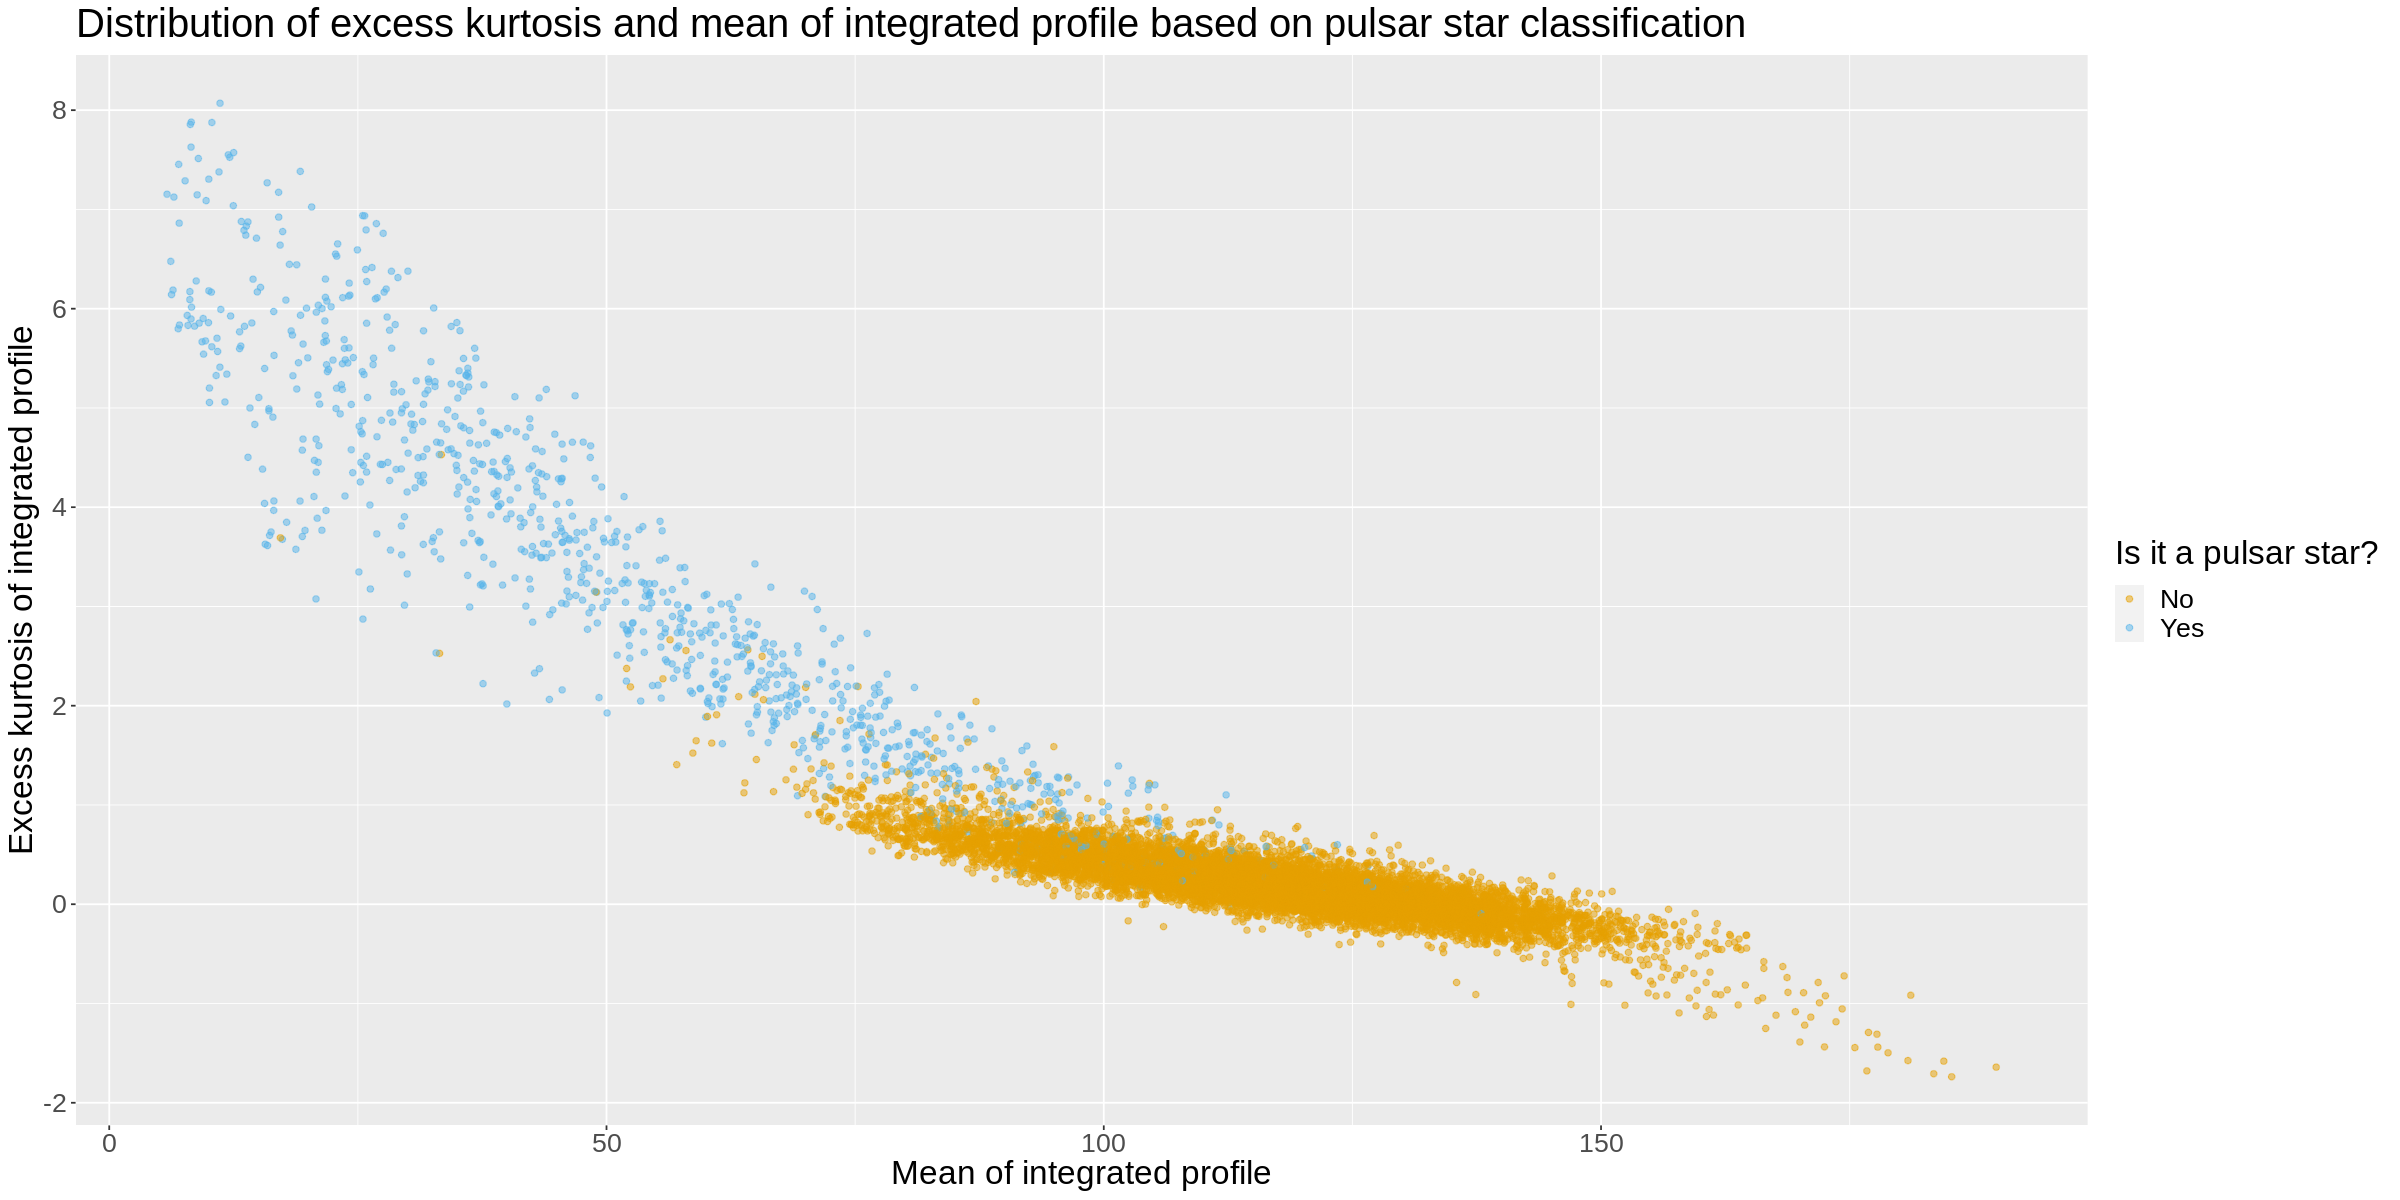

In [23]:
cbPalette <- c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#999999")
options(repr.plot.height = 10, repr.plot.width = 20)

pulsar_plot <- ggplot(pulsar, 
                        aes(x = Mean.of.the.integrated.profile, 
                            y = Excess.kurtosis.of.the.integrated.profile, 
                            color = target_class)) +
    geom_point(alpha = 0.5) + 
    labs(x = "Mean of integrated profile", 
         y = "Excess kurtosis of integrated profile", 
         color = "Is it a pulsar star?") +
    scale_color_manual(labels = c("No", "Yes"), values = cbPalette) + 
    ggtitle("Distribution of excess kurtosis and mean of integrated profile based on pulsar star classification") +
    theme(text = element_text(size = 20))

pulsar_plot

In the visualization above, we can see that candidates that are classified as pulsar stars typically fall in the upper left-hand corner of the plot area. On the other hand, candidates that are not pulsar stars fall in the lower right-hand corner of the plot area. Thus, as per our dataset pulsar stars tend to have lower values for mean of integrated profile and higher values for excess kurtosis of integrated profile. Based on this distribution, we can use these predictors to classify whether an unknown candidate is a pulsar star or not by using the K-nearest neighbour classification algorithm. 

Note:
There is overplotting in the lower right-hand corner (yellow points) due to the size of the dataset and also because of the distribution since 91% of the data are not pulsar stars. We tried lowering alpha to 0.5, increasing plot width/height, changing x and y scale but still weren't able to reduce overplotting.

**Exploring the dataset**

The following code was used to perform a summary of the dataset that was relevant for exploratory data analysis related to the planned analysis. It shows the percentage of candidates that are and not pulsar stars.

In [24]:
num_obs <- nrow(pulsar)
pulsar %>%
  group_by(target_class) %>%
  summarize(n = n(),
            percentage = n() / num_obs * 100)

`summarise()` ungrouping output (override with `.groups` argument)



target_class,n,percentage
<fct>,<int>,<dbl>
0,9798,90.781062
1,995,9.218938


According to the table, 91% of candidates are not classified as pulsar stars and 9% of them are. The proportion of stars that are not pulsar is very high compared to the stars which are pulsar

**Splitting data into training and testing dataset**

We split our pulsar dataset into training and testing dataset. We will be using the training dataset to train the model and we will use the testing dataset to evaluate the accuracy of our model. It is important to split the data so that our model doesn't see the testing dataset while training and gives us a fair accuracy. 

We used the golden ratio (75%-25%) to split the dataset. The training dataset will have 75% of the data and the testing dataset will have 25%. This is done by using the initial_split function in which we set prop to 0.75 and strata to target_class for stratification.

In [25]:
pulsar_split <- initial_split(pulsar, prop = 0.75, strata = target_class)

pulsar_training <- training(pulsar_split)
pulsar_testing <- testing(pulsar_split)

**Standardizing training dataset using recipe**

We used the recipe function to standardize the training dataset such that all variables in the dataset have a mean (center) of 0 and a standard deviation (scale) of 1. It is important to standardize the data so that a variable that has a much larger scale doesn't outweigh another variable with a smaller scale as this affects the distance calculated between data points

In [26]:
# used recipe to standardize data. 
pulsar_recipe <- recipe(target_class ~ ., data = pulsar_training) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

In the following code, we used nearest_neighbor function to build the model. The "rectangular" argument inside the function tells the model that we want to calculate the distance between two points which would be a line. Since we need to find a k value with highest accuracy, we set neighbors to tune(). 

As we are using the K nearest neighbor algorithm, we set the engine to "kknn" and since its a classification problem, we set the mode to "classification".

In [27]:
pulsar_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

In the code below we do cross validation by creating 5 folds using the training dataset. This eliminates the uncertainty of some data being lucky/unlucky to end up in the validation set. We will use 5 folds which is not very high but also not very to reduce computation time and also at the same time maintain accuracy.

In [28]:
pulsar_vfold <- vfold_cv(pulsar_training, v = 5, strata = target_class)

We then fit the model to our training dataset using workflow(). We add the recipe and the model we made before. As we are doing cross validation, we will be using the pulsar_vfold inside tunegrid and use grid = 10 to try 10 different k values. We used 10 values for k not very high but also not very to reduce computation time and also at the same time give us a value for k that has the highest accuracy. We then use collect_metrics() to find the accuracies of the different k values.

In [29]:
pulsar_results <- workflow() %>%
    add_recipe(pulsar_recipe) %>%
    add_model(pulsar_spec) %>%
    tune_grid(resamples = pulsar_vfold, grid = 10) %>%
    collect_metrics()

pulsar_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.9678814,5,0.001893726,Model1
2,roc_auc,binary,0.9324038,5,0.004948512,Model1
3,accuracy,binary,0.9773935,5,0.001361668,Model2
⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,roc_auc,binary,0.9540467,5,0.006748329,Model8
14,accuracy,binary,0.9798641,5,0.001709494,Model9
14,roc_auc,binary,0.9562052,5,0.006537893,Model9


**Visualizing the distribution of K neighbors and its accuracies**

We first filter the accuracy from the .metric column and then create a graph. We plot neighbors on the x axis and mean on the y axis. We used geom_point() and geom_line() to connect all the data points. We scaled the x axis such that the x axis scale incremented by one.

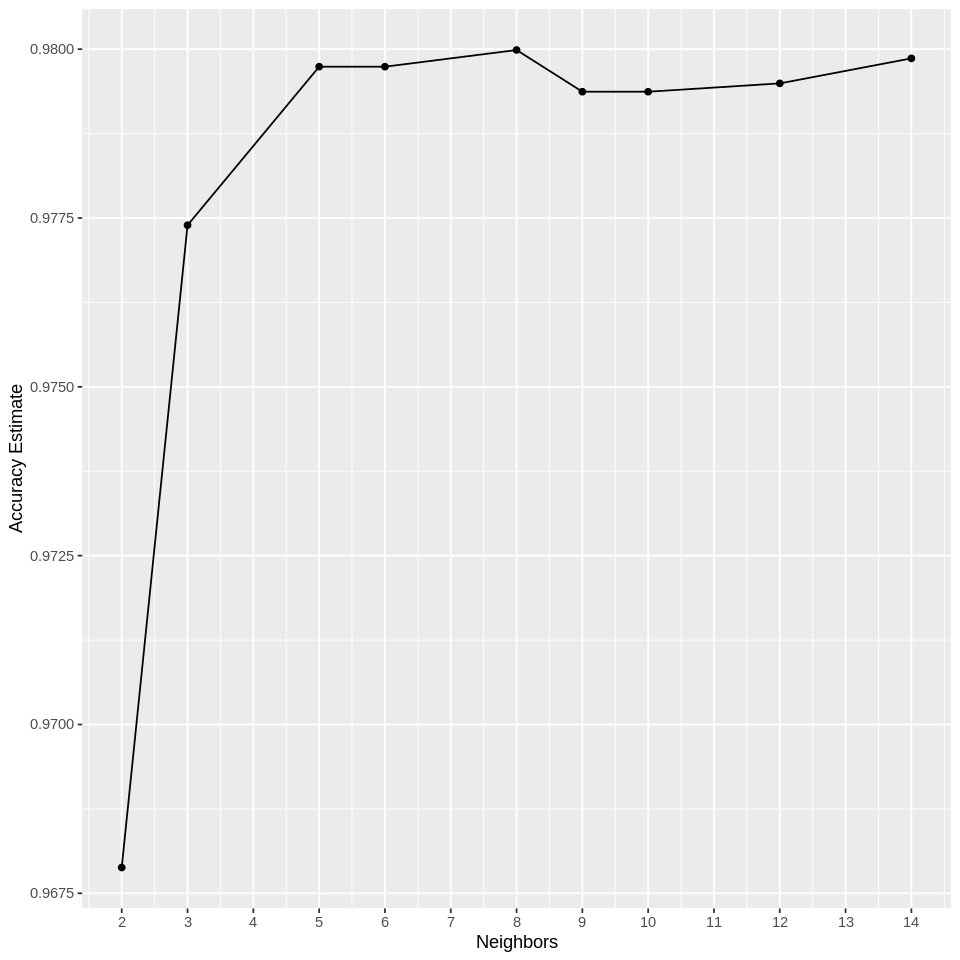

In [30]:
accuracies <- pulsar_results %>%
    filter(.metric == "accuracy")

options(repr.plot.height = 8, repr.plot.width = 8)

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 14, by = 1))
accuracy_versus_k

According to the plot above, K = 8 has the highest accuracy. We will be using this K value for our model as changing K to 7 or 9 doesn't affect the accuracy that much.

Assigning K value with highest accuracy to kmin

In [31]:
# filter function filters the maximum mean value and then pull(neighbors) pulls the corresponding neighbor
kmin <- accuracies %>%
    filter(mean == max(mean)) %>%
    pull(neighbors)

kmin

[1] 8

**Rebuilding model with best k value**

In the code below, we built the model specification again like we did before but instead of tuning the neighbors, we assign it kmin which was 8 evident from the plot and calculation above.

In [32]:
pulsar_model <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) %>%
    set_engine("kknn") %>%
    set_mode("classification")

We now fit the model again but this time to the training dataset and not the vfold.

In [33]:
pulsar_fit <- workflow() %>%
    add_recipe(pulsar_recipe) %>%
    add_model(pulsar_model) %>%
    fit(data = pulsar_training)

In the following code, we used the predict function to predict the target_class of the testing dataset using the model we made before. We then bind columns to compare the predicted vs the actual target class.

In [34]:
pulsar_prediction <- pulsar_fit %>%
    predict(pulsar_testing) %>%
    bind_cols(pulsar_testing)

pulsar_prediction

.pred_class,Mean.of.the.integrated.profile,Excess.kurtosis.of.the.integrated.profile,target_class
<fct>,<dbl>,<dbl>,<fct>
0,121.1562,0.3754847,0
0,109.1562,0.3941818,0
0,96.9375,0.4194056,0
⋮,⋮,⋮,⋮
0,117.2578,0.43257836,0
0,132.3359,-0.09598226,0
0,116.6953,0.31991017,0


**Accuracy Table:** We used the metrics function where we assign the actual result to truth and predictions to estimate.

In [35]:
pulsar_acc <- pulsar_prediction %>%
    metrics(truth = target_class, estimate = .pred_class)

pulsar_acc

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9733136
kap,binary,0.8366281


According to the table above, our model was able to correctly predict 97% of the testing dataset's target_class.

**Confusion Matrix:** We used the conf_mat function where we assign the actual result to truth and predictions to estimate.

In [36]:
pulsar_conf_mat <- pulsar_prediction %>%
    conf_mat(truth = target_class, estimate = .pred_class)

pulsar_conf_mat

          Truth
Prediction    0    1
         0 2420   49
         1   23  206

According to the table above, our model was able to correctly predict 2626 observations out of 2698 observations. 

### **Discussion**

### **References**

Co-learning Lounge, 2020. Predicting Pulsar Star: Pulsar candidates collected during the High Time Resolution Universe Survey. [online]. Kaggle.com. Available at <https://www.kaggle.com/colearninglounge/predicting-pulsar-starintermediate> [Accessed 14 August 2021].

Cofield, C., 2016. What Are Pulsars?. [online] Space.com. Available at: <https://www.space.com/32661-pulsars.html> [Accessed 14 August 2021].

Roberts, Nora, D. R. Lorimer, and M. Kramer. Handbook of pulsar astronomy. Vol. 4. Cambridge University Press, 2005. ISBN 9780521828239. 